In [1]:
# ! pip install scikit-survival

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
import platform

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# 모듈로 구현한 데이터 분석용 클래스 import 
from modules.DataAnalysis import DataCheck
from modules.DataAnalysis import DataPreprocessing
from modules.DataAnalysis import DataVisualize

import modules.DataModify as DataModify

# 모듈로 구현한 머신러닝 모델 import
from modules.TreeModels import TreeXGBoostCox
from modules.TreeModels import TreeRandomForestSurvival
import modules.ModelAnalysis as ModelAnalysis


In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
### matplotlib 에서 한글 및 음수 표현이 깨지는 현상 수정

system = platform.system()

if system == "Windows":     # Windows
    rcParams['font.family'] = 'Malgun Gothic'
elif system == "Darwin":    # macOS
    rcParams['font.family'] = 'AppleGothic'

rcParams['axes.unicode_minus'] = False

In [5]:
### 데이터 로드

input_file_path = './data/Tree_data.csv'

df = pd.read_csv(input_file_path)

### 전처리를 위한 객체 인스턴스 생성
dp = DataPreprocessing(df)

In [6]:
### 분석 결과를 바탕으로 드랍할 컬럼 설정
drop_cols = ['No', 'Plot', 'Adult', 'Subplot', 'Core', 'Census']
dp.set_drop_cols(drop_cols)

### 전처리 과정 실행 
# (데이터 드랍 -> 이상치 처리 -> 결측치 처리 -> 날짜값 통일 -> 라벨 데이터 통합 -> 인코딩)

encode = dp.run(encoding='label', return_anomaly=False)
display(encode)

,Species,Light_ISF,Light_Cat,Soil,Sterile,Conspecific,Myco,SoilMyco,PlantDate,AMF,EMF,Phenolics,Lignin,NSC,Time,Alive
0,0,0.106,0,0,0,0,0,0,0,22.00,0.00,0.79,13.86,12.15,14.0,0
1,1,0.106,0,1,0,0,1,1,1,15.82,31.07,6.54,20.52,19.29,115.5,2
2,2,0.106,0,0,0,0,1,0,1,24.45,28.19,4.71,24.74,15.01,63.0,0
3,0,0.080,0,0,0,0,0,0,0,22.23,0.00,0.64,14.29,12.36,14.0,0
4,0,0.060,1,0,0,0,0,0,0,21.15,0.00,0.77,10.85,11.20,14.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777,1,0.122,2,1,0,0,1,1,1,10.89,39.00,6.88,21.44,18.99,56.0,0
2778,3,0.111,0,3,0,0,0,1,0,40.89,0.00,2.18,9.15,11.88,56.0,0
2779,1,0.118,0,2,0,0,1,0,1,15.47,32.82,6.23,19.01,23.50,56.0,0
2780,1,0.118,0,1,0,0,1,1,1,11.96,37.67,6.86,21.13,19.10,56.0,0


### Cox 모델을 이용한 생존율 예측
  
##### Cox 모델이란?
t 시간 후의 생존율을 계산할 때, Event(사망)이 발생했는지 여부를 통해 계산함.
  
위험 점수를 통해 생존율을 예측하고, 해당 값을 이진 분류하여 정확도를 체크할 수 있음

##### Cox-XGBoost
X를 입력, y를 출력하는 기존 모델의 형태와 달리, X(특성), y(시간)을 입력값으로 받아 e(이벤트 발생 여부)에 관한 정보를 출력하는 모델이다.


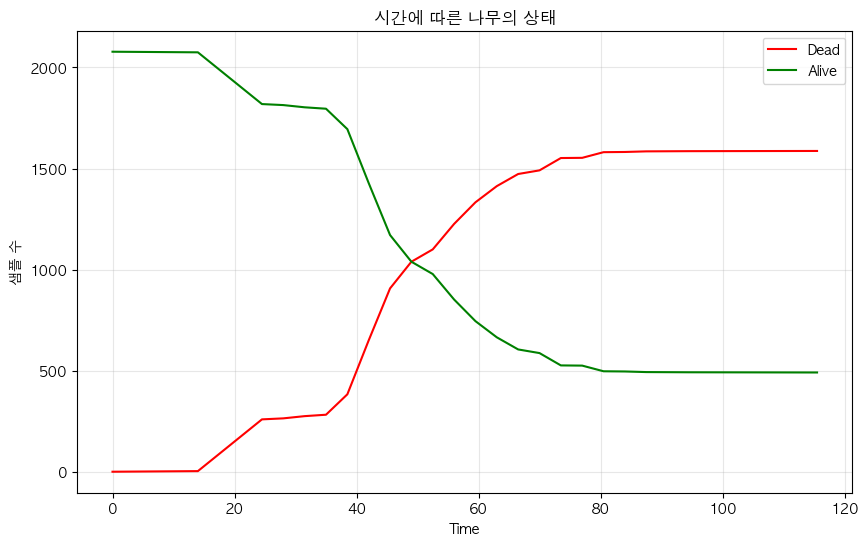

In [7]:
ModelAnalysis.show_alive_about_time(encode)

In [8]:
### 인코딩된 데이터를 X, y, e로 분할

# (X, y, e), (X, y, e)
# X : features, y : Event가 발생한 시간, e : Event (사망 - 0, 생존한 상태로 관측 종료 - 1)
train_set, test_set = DataModify.split_data_X_y_e(encode, random_state=42)

In [9]:
### Cox 모형을 기반으로 한 XGBoost 모델
xgb_cox = TreeXGBoostCox()

# 모델 학습
xgb_cox.fit(*train_set)

# 모델 평가
train_score = xgb_cox.score(*train_set, t=115.5)
test_score = xgb_cox.score(*test_set, t=115.5)

print(f'train score : {train_score}, test score : {test_score}')

train score : 0.7042696629213483, test score : 0.6822262118491921


In [10]:
### confusion matrix

# t = 115.5 일 때의 예측 결과에 대한 confusion matrix 반환
conf_ = xgb_cox.confusion_matrix(*test_set, t=115.5)

print(ModelAnalysis.calculate_metrics(conf_))

print(conf_)

{'Accuracy': np.float64(0.6822262118491921), 'Precision': np.float64(0.6821705426356589), 'Recall': np.float64(0.8301886792452831)}
[[116 123]
 [ 54 264]]


In [11]:
### Cox 모형을 기반으로 한 RandomForest 모델
rsf = TreeRandomForestSurvival()

# 모델 학습
rsf.fit(*train_set)

# 모델 평가
train_score = rsf.score(*train_set, t=115.5)
test_score = rsf.score(*test_set, t=115.5)

print(f'train score : {train_score}, test score : {test_score}')

train score : 0.8435955056179776, test score : 0.7504488330341114


In [12]:
### confusion matrix

# t = 115.5 일 때의 예측 결과에 대한 confusion matrix 반환
conf_ = rsf.confusion_matrix(*test_set, t=115.5)

print(ModelAnalysis.calculate_metrics(conf_))

print(conf_)

{'Accuracy': np.float64(0.7504488330341114), 'Precision': np.float64(0.7324675324675325), 'Recall': np.float64(0.8867924528301887)}
[[136 103]
 [ 36 282]]


In [13]:
### KFold를 기반으로 한 Cox-XGBoost 모델 테스트

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_accuracy = []

for train, validation in kfold.split(train_set[0]) :
    X, y, e = train_set

    X_train, y_train, e_train = X.iloc[train], y.iloc[train], e.iloc[train]
    X_val, y_val, e_val = X.iloc[validation], y.iloc[validation], e.iloc[validation]

    xgb_cox.fit(X_train, y_train, e_train)
    conf_ = xgb_cox.confusion_matrix(X_val, y_val, e_val, t=115.5)

    cv_accuracy.append(ModelAnalysis.calculate_metrics(conf_))



In [14]:
cv_df = pd.DataFrame(cv_accuracy)

cv_df.mean()


Accuracy     0.693034
Precision    0.683833
Recall       0.863774
dtype: float64

In [15]:
### KFold를 기반으로 한 RandomSurvivalForest 모델 테스트

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_accuracy = []

for train, validation in kfold.split(train_set[0]) :
    X, y, e = train_set

    X_train, y_train, e_train = X.iloc[train], y.iloc[train], e.iloc[train]
    X_val, y_val, e_val = X.iloc[validation], y.iloc[validation], e.iloc[validation]

    rsf.fit(X_train, y_train, e_train)
    conf_ = rsf.confusion_matrix(X_val, y_val, e_val, t=115.5)

    cv_accuracy.append(ModelAnalysis.calculate_metrics(conf_))



In [16]:
cv_df = pd.DataFrame(cv_accuracy)

cv_df.mean()

Accuracy     0.735281
Precision    0.721392
Recall       0.873232
dtype: float64

In [17]:
### X, y 형태로 데이터를 전달하기 위해 수정

X_train, y, e = train_set

y_train = pd.DataFrame({'Time': y, 'Alive': e})


X_test, y, e = test_set

y_test = pd.DataFrame({'Time': y, 'Alive': e})


In [18]:
# rsf_grid = TreeRandomForestSurvival()

# params = {
#     'n_estimators' : range(10, 100, 10),
#     'max_depth' : range(1,6), 
#     'min_samples_split' : range(1, 4),
#     'min_samples_leaf' : range(1, 4),
#     'threshold' : [0.4, 0.5, 0.6]
# }


# grid = GridSearchCV(rsf_grid, params, cv=3)

# grid.fit(X_train, y_train)

# print("최적의 파라미터 : ", grid.best_params_)
# print("최적화된 모델 객체 : ", grid.best_estimator_)
# print("최적화된 점수 : ", grid.best_score_)

In [19]:
rsf_optim = TreeRandomForestSurvival(max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=10, threshold=0.5)
rsf_optim.fit(*train_set)

,n_estimators,10
,max_depth,3
,max_features,'sqrt'
,min_samples_split,3
,min_samples_leaf,1
,random_state,None
,threshold,0.5


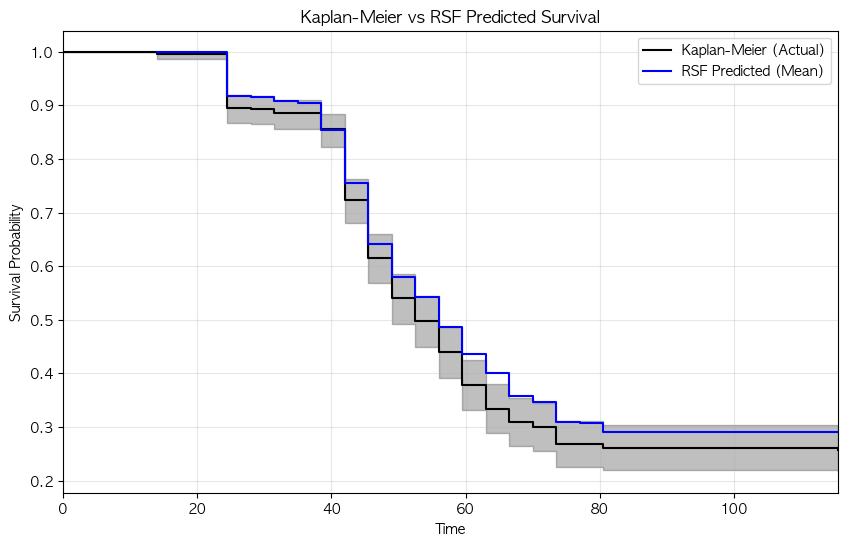

In [20]:
ModelAnalysis.compare_km_and_model(rsf, *test_set, max_time=115.5)


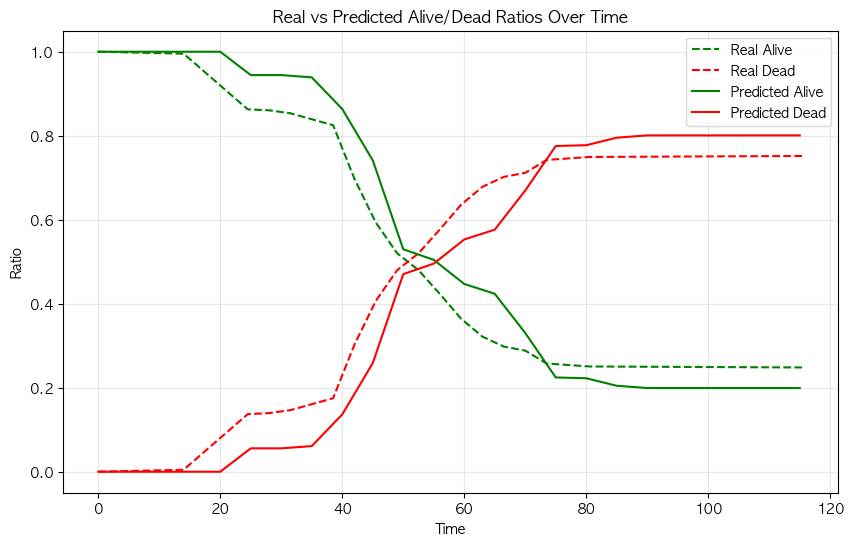

In [21]:
encode_selected = encode.loc[test_set[0]. index]

ModelAnalysis.compare_real_vs_pred_alive_dead(rsf, encode_selected, test_set[0], time_points=np.arange(0, 115.5, 5), threshold=0.6)

{'Accuracy': np.float64(0.7809694793536804), 'Precision': np.float64(0.8333333333333334), 'Recall': np.float64(0.7704402515723271)}
[[190  49]
 [ 73 245]]


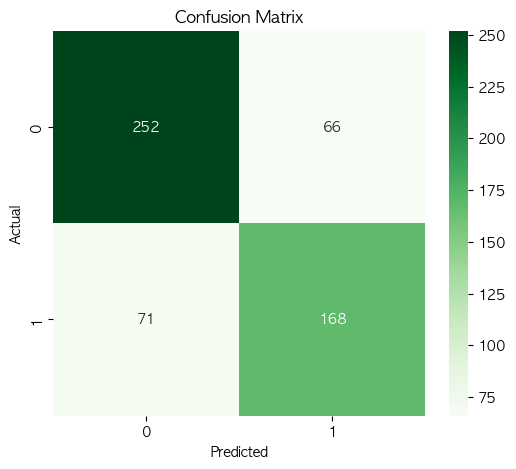

In [22]:
conf_ = rsf_optim.confusion_matrix(*test_set, t=115.5)

print(ModelAnalysis.calculate_metrics(conf_))

print(conf_)

conf_ = [[252, 66], [71, 168]]
ModelAnalysis.show_confusion_matrix(conf_)

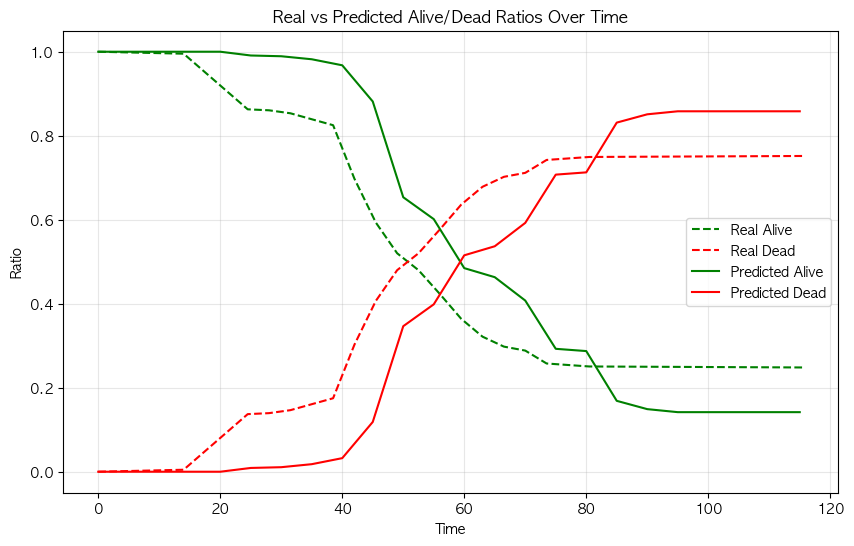

In [23]:
### Cox 모형을 기반으로 한 XGBoost 모델
xgb_cox = TreeXGBoostCox()

# 모델 학습
xgb_cox.fit(*train_set)

ModelAnalysis.compare_real_vs_pred_alive_dead(xgb_cox, encode_selected, test_set[0], time_points=np.arange(0, 115.5, 5), threshold=0.55)

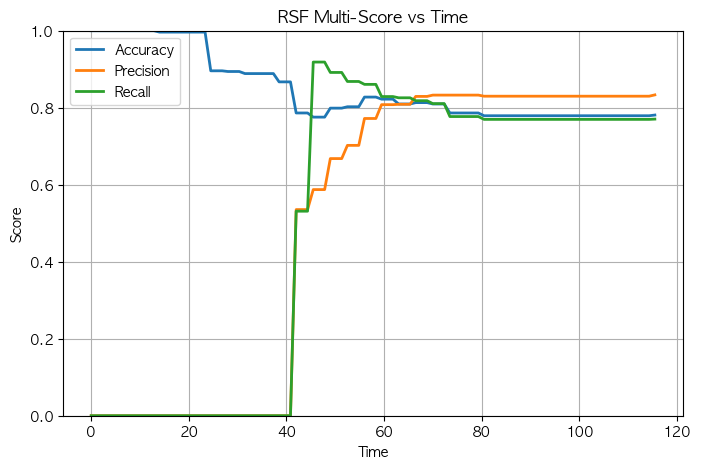

In [24]:
ModelAnalysis.rsf_score_over_time(rsf_optim, test_set, t_max=115.5, n_points=100)


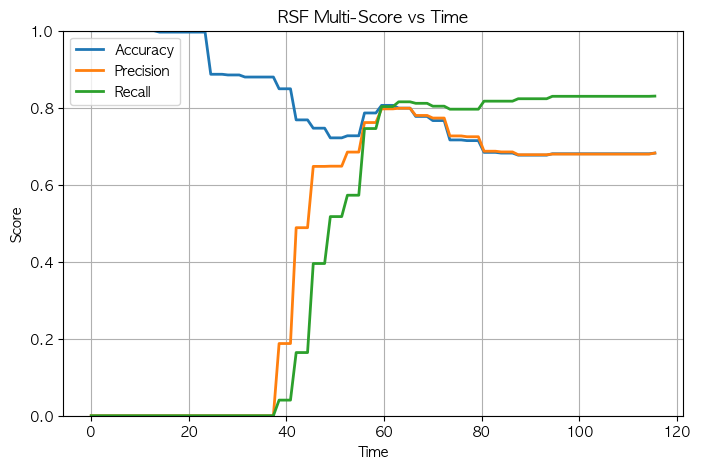

In [25]:
ModelAnalysis.rsf_score_over_time(xgb_cox, test_set, t_max=115.5, n_points=100)